**В этом ноутбуке** рассматриваются разные методы стекинга моделей, полученных в других ноутбуках

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

In [3]:
def pred_proc(pred):
    pred = np.round(np.clip(pred, 0, 10))
    return pred.astype(int)

def cv_loop(oof_df, y, model):
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=17)
    
    scores = []
    
    for training_index, validation_index in tqdm_notebook(folds.split(oof_df), total=n_fold):
        X_train = oof_df.iloc[training_index]
        y_train = y[training_index]
        X_valid = oof_df.iloc[validation_index]
        y_valid = y[validation_index]
        
        model.fit(X_train, y_train)
        
        # скор на валидации
        preds = model.predict(X_valid)
        preds = np.round(np.clip(preds, 0, 10)).astype(int)
        score = f1_score(y_valid, preds, average = 'macro')
        scores.append(score)
        print(score)
        
    return scores

### 1. Стекинг LGBM и Catboost

### 1.1. Усреднение ответов

In [4]:
lgb_preds = np.load('for_stacking/lgb13_test_preds.npy')
cb_preds = np.load('for_stacking/preds_best_catboost.npy')

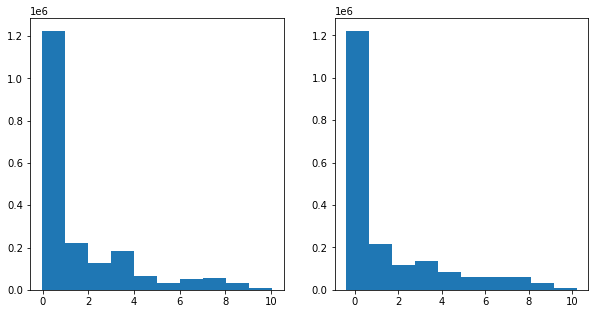

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(lgb_preds)
plt.subplot(122)
plt.hist(cb_preds)
plt.show()

In [5]:
preds = 0.5*lgb_preds + 0.5*cb_preds
preds = pred_proc(preds)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv("lgb13_bestcb.csv", index=False, float_format='%.4f')

### 1.2. Метамодель - линейная регрессия

In [3]:
lgb_oof = np.load('for_stacking/lgb13_oof_preds.npy')
cb_oof = np.load('for_stacking/oof_best_catboost.npy')

In [4]:
oof_df = pd.DataFrame({'lgb_oof': lgb_oof, 'cb_oof': cb_oof})
oof_df.head()

,lgb_oof,cb_oof
0,0.132022,0.030460
1,0.097993,-0.028301
2,0.081194,-0.085979
3,0.138549,0.036849
4,0.060607,0.035619


In [9]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
y = train.open_channels.values
train = train.drop(columns=['open_channels'])

In [39]:
X_train, X_val, y_train, y_val = train_test_split(oof_df, y,
                                                  random_state=17,
                                                  test_size=0.3)

In [40]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

Wall time: 601 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
preds = lr.predict(X_val)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
score = f1_score(y_val, preds, average = 'macro')
print(f'score on val: {score}')

score on val: 0.937807230681399


In [42]:
scores = cv_loop(oof_df, y, LinearRegression())
print(scores)
print(np.mean(scores))


[0.9378667233513109, 0.938132013690785, 0.9376538834963697, 0.9393951023074935, 0.9386472946846514]
0.938339003506122


In [25]:
test_df = pd.DataFrame({'lgb_oof': lgb_preds, 'cb_oof': cb_preds})

In [28]:
lr.fit(oof_df, y)
print(lr.coef_)
preds = lr.predict(test_df)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv('lgb_cb_linreg.csv', index=False, float_format='%.4f')

[0.83597733 0.16406567]


**Результат:** 0.940 на public lb

### 1.3. Метамодель - XGBRegressor

In [32]:
%%time
xg = XGBRegressor()
xg.fit(X_train, y_train)
preds = xg.predict(X_val)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
score = f1_score(y_val, preds, average = 'macro')
print(f'score on val: {score}')

[11:22:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
score on val: 0.9377933690895529
Wall time: 1min 51s


In [33]:
xg.fit(oof_df, y)
preds = xg.predict(test_df)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv('lgb_cb_xgb.csv', index=False, float_format='%.4f')

[11:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:25] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


**Результат:** 0.824 на public lb

### 2. Добавим oof-предсказания RandomForest

### 2.1. Метамодель - линейная регрессия

In [6]:
rf_oof = np.load('for_stacking/rf1_oof_preds.npy')
lgb_oof = np.load('for_stacking/lgb13_oof_preds.npy')
cb_oof = np.load('for_stacking/oof_best_catboost.npy')

In [7]:
oof_df = pd.DataFrame({'lgb_oof': lgb_oof, 'cb_oof': cb_oof, 
                       'rf_oof': rf_oof})
oof_df.head()

,lgb_oof,cb_oof,rf_oof
0,0.132022,0.030460,0.0
1,0.097993,-0.028301,0.0
2,0.081194,-0.085979,0.0
3,0.138549,0.036849,0.0
4,0.060607,0.035619,0.0


In [7]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
y = train.open_channels.values
train = train.drop(columns=['open_channels'])

In [13]:
X_train, X_val, y_train, y_val = train_test_split(oof_df, y,
                                                  random_state=17,
                                                  test_size=0.3)


In [18]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.coef_)

[0.7904124  0.16517715 0.04447739]
Wall time: 818 ms


In [19]:
preds = lr.predict(X_val)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
score = f1_score(y_val, preds, average = 'macro')

print(f'score on val: {score}')

score on val: 0.9378588402608


In [30]:
scores = cv_loop(oof_df, y, LinearRegression())
print(scores)
print(np.mean(scores))


[0.9378524357477883, 0.9381910752966391, 0.9376301521633792, 0.9394900835071932, 0.9385950090858696]
0.9383517511601738


### 3. Добавим вероятности из ноутбука по RandomForest

### 3.1. Метамодель - LinearRegression()

In [8]:
lgb_oof = np.load('for_stacking/lgb13_oof_preds.npy')
cb_oof = np.load('for_stacking/oof_best_catboost.npy')
rf_oof_probs = np.load('for_stacking/rf_train_probs.npy')

oof_df = pd.DataFrame({'lgb_oof': lgb_oof, 
                       'cb_oof': cb_oof})
for i in range(11):
    oof_df[f'rf_oof_prob{str(i)}'] = rf_oof_probs[:, i]

In [9]:
scores = cv_loop(oof_df, y, LinearRegression())
print(scores)
print(np.mean(scores))

0.9379607836734138
0.9381939577977526
0.9377431802136612
0.9395857113729804
0.9387336790542435

[0.9379607836734138, 0.9381939577977526, 0.9377431802136612, 0.9395857113729804, 0.9387336790542435]
0.9384434624224103


In [10]:
%%time
X_train, X_val, y_train, y_val = train_test_split(oof_df, y,
                                                  random_state=17,
                                                  test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.coef_)

preds = lr.predict(X_val)
preds = np.round(np.clip(preds, 0, 10)).astype(int)
score = f1_score(y_val, preds, average = 'macro')

print(f'score on val: {score}')

[ 7.25332303e-01  1.31141734e-01 -7.20452826e-01 -5.76616182e-01
 -4.33604634e-01 -2.89085199e-01 -1.45589179e-01 -3.09331149e-04
  1.39950744e-01  2.85790302e-01  4.30085623e-01  5.75450079e-01
  7.34380604e-01]
score on val: 0.9378757522818262
Wall time: 3.43 s


In [75]:
lgb_preds = np.load('for_stacking/lgb13_test_preds.npy')
cb_preds = np.load('for_stacking/preds_best_catboost.npy')
rf_probs = np.load('for_stacking/rf_test_probs.npy')

test_df = pd.DataFrame({'lgb_oof': lgb_preds, 'cb_oof': cb_preds})
for i in range(11):
    test_df[f'rf_oof_prob{str(i)}'] = rf_probs[:, i]

In [12]:
lr = LinearRegression()
lr.fit(oof_df, y)

print(lr.coef_)

preds = lr.predict(test_df)
preds = np.round(np.clip(preds, 0, 10)).astype(int)

sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv('stacking3.1.1.csv', index=False, float_format='%.4f')

[ 7.23415356e-01  1.32802225e-01 -1.19220250e+10 -1.19220250e+10
 -1.19220250e+10 -1.19220250e+10 -1.19220250e+10 -1.19220250e+10
 -1.19220250e+10 -1.19220250e+10 -1.19220250e+10 -1.19220250e+10
 -1.19220250e+10]


### 3.2. Метамодель - XGBClassifier()

In [7]:
scores = cv_loop(oof_df, y, XGBClassifier(verbosity=1,
                                          n_estimators=1))
print(scores)
print(np.mean(scores))

[19:48:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:48:28] INFO: src/tree/updater_prune.cc:74: tree prun

### 3.3. Метамодель - CatBoostClassifier

In [71]:
from catboost import CatBoostClassifier

In [72]:
cb = CatBoostClassifier(iterations=1500,
                        verbose=1)
cb.fit(oof_df, y)

Learning rate set to 0.086731
0:	learn: 1.7197795	total: 5.87s	remaining: 2h 26m 39s
1:	learn: 1.4436677	total: 10.1s	remaining: 2h 6m 15s
2:	learn: 1.2474957	total: 14.2s	remaining: 1h 58m 20s
3:	learn: 1.0976631	total: 18.4s	remaining: 1h 54m 32s
4:	learn: 0.9609647	total: 22.5s	remaining: 1h 52m 10s
5:	learn: 0.8643736	total: 26.6s	remaining: 1h 50m 25s
6:	learn: 0.7827403	total: 30.8s	remaining: 1h 49m 34s
7:	learn: 0.7139835	total: 35.1s	remaining: 1h 49m
8:	learn: 0.6556434	total: 39.4s	remaining: 1h 48m 42s
9:	learn: 0.6031464	total: 43.7s	remaining: 1h 48m 27s
10:	learn: 0.5563732	total: 47.9s	remaining: 1h 48m 5s
11:	learn: 0.5158112	total: 52.2s	remaining: 1h 47m 56s
12:	learn: 0.4792302	total: 56.4s	remaining: 1h 47m 31s
13:	learn: 0.4472814	total: 1m	remaining: 1h 47m 26s
14:	learn: 0.4181340	total: 1m 4s	remaining: 1h 47m 12s
15:	learn: 0.3918102	total: 1m 9s	remaining: 1h 47m 8s
16:	learn: 0.3652644	total: 1m 13s	remaining: 1h 47m 8s
17:	learn: 0.3438955	total: 1m 18s	rem

144:	learn: 0.0870569	total: 10m 49s	remaining: 1h 41m 13s
145:	learn: 0.0870225	total: 10m 54s	remaining: 1h 41m 8s
146:	learn: 0.0869302	total: 10m 58s	remaining: 1h 41m 3s
147:	learn: 0.0868901	total: 11m 3s	remaining: 1h 40m 58s
148:	learn: 0.0868440	total: 11m 7s	remaining: 1h 40m 53s
149:	learn: 0.0868148	total: 11m 12s	remaining: 1h 40m 48s
150:	learn: 0.0867915	total: 11m 16s	remaining: 1h 40m 43s
151:	learn: 0.0867220	total: 11m 20s	remaining: 1h 40m 39s
152:	learn: 0.0866779	total: 11m 25s	remaining: 1h 40m 33s
153:	learn: 0.0866202	total: 11m 29s	remaining: 1h 40m 29s
154:	learn: 0.0865819	total: 11m 34s	remaining: 1h 40m 24s
155:	learn: 0.0865476	total: 11m 38s	remaining: 1h 40m 19s
156:	learn: 0.0865060	total: 11m 43s	remaining: 1h 40m 14s
157:	learn: 0.0864418	total: 11m 47s	remaining: 1h 40m 9s
158:	learn: 0.0864173	total: 11m 51s	remaining: 1h 40m 4s
159:	learn: 0.0863758	total: 11m 56s	remaining: 1h 39m 59s
160:	learn: 0.0863426	total: 12m	remaining: 1h 39m 54s
161:	le

285:	learn: 0.0838376	total: 21m 24s	remaining: 1h 30m 50s
286:	learn: 0.0838325	total: 21m 28s	remaining: 1h 30m 46s
287:	learn: 0.0838289	total: 21m 33s	remaining: 1h 30m 41s
288:	learn: 0.0838228	total: 21m 37s	remaining: 1h 30m 37s
289:	learn: 0.0838001	total: 21m 42s	remaining: 1h 30m 33s
290:	learn: 0.0837975	total: 21m 46s	remaining: 1h 30m 29s
291:	learn: 0.0837757	total: 21m 51s	remaining: 1h 30m 25s
292:	learn: 0.0837690	total: 21m 55s	remaining: 1h 30m 20s
293:	learn: 0.0837465	total: 22m	remaining: 1h 30m 18s
294:	learn: 0.0837320	total: 22m 11s	remaining: 1h 30m 38s
295:	learn: 0.0837255	total: 22m 16s	remaining: 1h 30m 36s
296:	learn: 0.0837211	total: 22m 21s	remaining: 1h 30m 32s
297:	learn: 0.0837201	total: 22m 25s	remaining: 1h 30m 27s
298:	learn: 0.0837116	total: 22m 30s	remaining: 1h 30m 23s
299:	learn: 0.0837036	total: 22m 34s	remaining: 1h 30m 18s
300:	learn: 0.0836881	total: 22m 38s	remaining: 1h 30m 13s
301:	learn: 0.0836730	total: 22m 43s	remaining: 1h 30m 8s
30

425:	learn: 0.0830476	total: 32m 48s	remaining: 1h 22m 44s
426:	learn: 0.0830344	total: 32m 53s	remaining: 1h 22m 40s
427:	learn: 0.0830336	total: 32m 58s	remaining: 1h 22m 36s
428:	learn: 0.0830256	total: 33m 3s	remaining: 1h 22m 32s
429:	learn: 0.0830241	total: 33m 8s	remaining: 1h 22m 28s
430:	learn: 0.0830234	total: 33m 13s	remaining: 1h 22m 24s
431:	learn: 0.0830226	total: 33m 18s	remaining: 1h 22m 21s
432:	learn: 0.0830212	total: 33m 23s	remaining: 1h 22m 17s
433:	learn: 0.0830181	total: 33m 28s	remaining: 1h 22m 13s
434:	learn: 0.0830169	total: 33m 33s	remaining: 1h 22m 10s
435:	learn: 0.0830129	total: 33m 39s	remaining: 1h 22m 7s
436:	learn: 0.0830098	total: 33m 44s	remaining: 1h 22m 3s
437:	learn: 0.0829957	total: 33m 49s	remaining: 1h 22m
438:	learn: 0.0829942	total: 33m 54s	remaining: 1h 21m 56s
439:	learn: 0.0829915	total: 33m 59s	remaining: 1h 21m 52s
440:	learn: 0.0829876	total: 34m 4s	remaining: 1h 21m 49s
441:	learn: 0.0829865	total: 34m 9s	remaining: 1h 21m 45s
442:	le

565:	learn: 0.0826821	total: 44m 39s	remaining: 1h 13m 42s
566:	learn: 0.0826806	total: 44m 44s	remaining: 1h 13m 37s
567:	learn: 0.0826765	total: 44m 50s	remaining: 1h 13m 34s
568:	learn: 0.0826757	total: 44m 55s	remaining: 1h 13m 30s
569:	learn: 0.0826728	total: 45m	remaining: 1h 13m 26s
570:	learn: 0.0826716	total: 45m 5s	remaining: 1h 13m 22s
571:	learn: 0.0826706	total: 45m 10s	remaining: 1h 13m 18s
572:	learn: 0.0826689	total: 45m 16s	remaining: 1h 13m 13s
573:	learn: 0.0826661	total: 45m 21s	remaining: 1h 13m 9s
574:	learn: 0.0826538	total: 45m 26s	remaining: 1h 13m 5s
575:	learn: 0.0826528	total: 45m 31s	remaining: 1h 13m 1s
576:	learn: 0.0826508	total: 45m 36s	remaining: 1h 12m 57s
577:	learn: 0.0826466	total: 45m 41s	remaining: 1h 12m 52s
578:	learn: 0.0826456	total: 45m 46s	remaining: 1h 12m 48s
579:	learn: 0.0826446	total: 45m 51s	remaining: 1h 12m 44s
580:	learn: 0.0826436	total: 45m 56s	remaining: 1h 12m 39s
581:	learn: 0.0826424	total: 46m 1s	remaining: 1h 12m 35s
582:	l

707:	learn: 0.0824375	total: 56m 46s	remaining: 1h 3m 31s
708:	learn: 0.0824369	total: 56m 52s	remaining: 1h 3m 26s
709:	learn: 0.0824355	total: 56m 56s	remaining: 1h 3m 21s
710:	learn: 0.0824336	total: 57m 1s	remaining: 1h 3m 17s
711:	learn: 0.0824327	total: 57m 7s	remaining: 1h 3m 12s
712:	learn: 0.0824295	total: 57m 12s	remaining: 1h 3m 8s
713:	learn: 0.0824284	total: 57m 17s	remaining: 1h 3m 3s
714:	learn: 0.0824270	total: 57m 22s	remaining: 1h 2m 59s
715:	learn: 0.0824258	total: 57m 27s	remaining: 1h 2m 54s
716:	learn: 0.0824225	total: 57m 32s	remaining: 1h 2m 50s
717:	learn: 0.0824214	total: 57m 37s	remaining: 1h 2m 45s
718:	learn: 0.0824175	total: 57m 42s	remaining: 1h 2m 40s
719:	learn: 0.0824157	total: 57m 47s	remaining: 1h 2m 36s
720:	learn: 0.0824150	total: 57m 52s	remaining: 1h 2m 31s
721:	learn: 0.0824128	total: 57m 57s	remaining: 1h 2m 27s
722:	learn: 0.0824110	total: 58m 3s	remaining: 1h 2m 23s
723:	learn: 0.0824094	total: 58m 8s	remaining: 1h 2m 18s
724:	learn: 0.082408

851:	learn: 0.0822062	total: 1h 9m 11s	remaining: 52m 37s
852:	learn: 0.0822058	total: 1h 9m 15s	remaining: 52m 32s
853:	learn: 0.0822052	total: 1h 9m 20s	remaining: 52m 27s
854:	learn: 0.0822046	total: 1h 9m 25s	remaining: 52m 22s
855:	learn: 0.0822027	total: 1h 9m 30s	remaining: 52m 17s
856:	learn: 0.0822019	total: 1h 9m 35s	remaining: 52m 12s
857:	learn: 0.0822012	total: 1h 9m 40s	remaining: 52m 7s
858:	learn: 0.0822003	total: 1h 9m 45s	remaining: 52m 3s
859:	learn: 0.0821992	total: 1h 9m 50s	remaining: 51m 58s
860:	learn: 0.0821989	total: 1h 9m 54s	remaining: 51m 53s
861:	learn: 0.0821984	total: 1h 9m 59s	remaining: 51m 48s
862:	learn: 0.0821972	total: 1h 10m 4s	remaining: 51m 43s
863:	learn: 0.0821964	total: 1h 10m 9s	remaining: 51m 38s
864:	learn: 0.0821958	total: 1h 10m 14s	remaining: 51m 34s
865:	learn: 0.0821944	total: 1h 10m 19s	remaining: 51m 29s
866:	learn: 0.0821926	total: 1h 10m 25s	remaining: 51m 24s
867:	learn: 0.0821916	total: 1h 10m 29s	remaining: 51m 19s
868:	learn: 

992:	learn: 0.0820390	total: 1h 21m 6s	remaining: 41m 24s
993:	learn: 0.0820383	total: 1h 21m 11s	remaining: 41m 19s
994:	learn: 0.0820377	total: 1h 21m 16s	remaining: 41m 15s
995:	learn: 0.0820370	total: 1h 21m 21s	remaining: 41m 10s
996:	learn: 0.0820358	total: 1h 21m 26s	remaining: 41m 5s
997:	learn: 0.0820338	total: 1h 21m 32s	remaining: 41m
998:	learn: 0.0820327	total: 1h 21m 37s	remaining: 40m 55s
999:	learn: 0.0820316	total: 1h 21m 42s	remaining: 40m 51s
1000:	learn: 0.0820307	total: 1h 21m 47s	remaining: 40m 46s
1001:	learn: 0.0820298	total: 1h 21m 52s	remaining: 40m 41s
1002:	learn: 0.0820285	total: 1h 21m 58s	remaining: 40m 37s
1003:	learn: 0.0820274	total: 1h 22m 3s	remaining: 40m 32s
1004:	learn: 0.0820264	total: 1h 22m 8s	remaining: 40m 27s
1005:	learn: 0.0820259	total: 1h 22m 14s	remaining: 40m 22s
1006:	learn: 0.0820250	total: 1h 22m 19s	remaining: 40m 18s
1007:	learn: 0.0820239	total: 1h 22m 24s	remaining: 40m 13s
1008:	learn: 0.0820232	total: 1h 22m 29s	remaining: 40m 

1130:	learn: 0.0818743	total: 1h 32m 48s	remaining: 30m 16s
1131:	learn: 0.0818734	total: 1h 32m 54s	remaining: 30m 12s
1132:	learn: 0.0818729	total: 1h 32m 59s	remaining: 30m 7s
1133:	learn: 0.0818723	total: 1h 33m 4s	remaining: 30m 2s
1134:	learn: 0.0818717	total: 1h 33m 10s	remaining: 29m 57s
1135:	learn: 0.0818711	total: 1h 33m 15s	remaining: 29m 52s
1136:	learn: 0.0818694	total: 1h 33m 20s	remaining: 29m 48s
1137:	learn: 0.0818685	total: 1h 33m 25s	remaining: 29m 43s
1138:	learn: 0.0818674	total: 1h 33m 30s	remaining: 29m 38s
1139:	learn: 0.0818665	total: 1h 33m 36s	remaining: 29m 33s
1140:	learn: 0.0818652	total: 1h 33m 41s	remaining: 29m 28s
1141:	learn: 0.0818634	total: 1h 33m 46s	remaining: 29m 23s
1142:	learn: 0.0818630	total: 1h 33m 51s	remaining: 29m 18s
1143:	learn: 0.0818616	total: 1h 33m 56s	remaining: 29m 14s
1144:	learn: 0.0818597	total: 1h 34m 1s	remaining: 29m 9s
1145:	learn: 0.0818587	total: 1h 34m 6s	remaining: 29m 4s
1146:	learn: 0.0818580	total: 1h 34m 11s	remain

1268:	learn: 0.0817430	total: 1h 44m 35s	remaining: 19m 2s
1269:	learn: 0.0817426	total: 1h 44m 40s	remaining: 18m 57s
1270:	learn: 0.0817419	total: 1h 44m 45s	remaining: 18m 52s
1271:	learn: 0.0817413	total: 1h 44m 50s	remaining: 18m 47s
1272:	learn: 0.0817407	total: 1h 44m 55s	remaining: 18m 42s
1273:	learn: 0.0817381	total: 1h 45m 1s	remaining: 18m 37s
1274:	learn: 0.0817347	total: 1h 45m 6s	remaining: 18m 32s
1275:	learn: 0.0817329	total: 1h 45m 11s	remaining: 18m 27s
1276:	learn: 0.0817320	total: 1h 45m 16s	remaining: 18m 22s
1277:	learn: 0.0817316	total: 1h 45m 21s	remaining: 18m 18s
1278:	learn: 0.0817311	total: 1h 45m 26s	remaining: 18m 13s
1279:	learn: 0.0817302	total: 1h 45m 31s	remaining: 18m 8s
1280:	learn: 0.0817294	total: 1h 45m 36s	remaining: 18m 3s
1281:	learn: 0.0817289	total: 1h 45m 40s	remaining: 17m 58s
1282:	learn: 0.0817283	total: 1h 45m 45s	remaining: 17m 53s
1283:	learn: 0.0817275	total: 1h 45m 50s	remaining: 17m 48s
1284:	learn: 0.0817270	total: 1h 45m 55s	rema

1407:	learn: 0.0816196	total: 1h 56m 22s	remaining: 7m 36s
1408:	learn: 0.0816187	total: 1h 56m 27s	remaining: 7m 31s
1409:	learn: 0.0816181	total: 1h 56m 32s	remaining: 7m 26s
1410:	learn: 0.0816176	total: 1h 56m 38s	remaining: 7m 21s
1411:	learn: 0.0816170	total: 1h 56m 43s	remaining: 7m 16s
1412:	learn: 0.0816160	total: 1h 56m 48s	remaining: 7m 11s
1413:	learn: 0.0816141	total: 1h 56m 53s	remaining: 7m 6s
1414:	learn: 0.0816134	total: 1h 56m 58s	remaining: 7m 1s
1415:	learn: 0.0816127	total: 1h 57m 3s	remaining: 6m 56s
1416:	learn: 0.0816123	total: 1h 57m 9s	remaining: 6m 51s
1417:	learn: 0.0816108	total: 1h 57m 14s	remaining: 6m 46s
1418:	learn: 0.0816097	total: 1h 57m 19s	remaining: 6m 41s
1419:	learn: 0.0816065	total: 1h 57m 24s	remaining: 6m 36s
1420:	learn: 0.0816059	total: 1h 57m 29s	remaining: 6m 31s
1421:	learn: 0.0816055	total: 1h 57m 34s	remaining: 6m 26s
1422:	learn: 0.0816046	total: 1h 57m 39s	remaining: 6m 21s
1423:	learn: 0.0816038	total: 1h 57m 44s	remaining: 6m 17s
1

In [79]:
preds = cb.predict(test_df)
preds = pred_proc(preds)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv("stacking3.3.csv", index=False, float_format='%.4f')

### 4. Разный блендинг на разных батчах

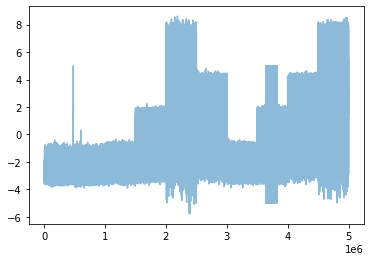

In [31]:
plt.plot(np.arange(0, len(train.signal.values)), train.signal.values,
         alpha=0.5)

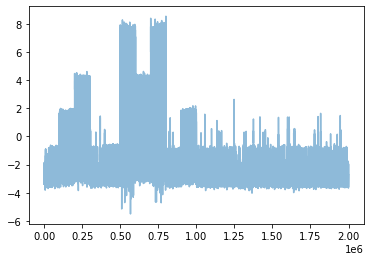

In [32]:
plt.plot(np.arange(0, len(test.signal.values)), test.signal.values,
         alpha=0.5)

In [26]:
for i in range(10):
    print(np.mean(train.signal.values[i*500000:(i+1)*500000]))

-2.681406359199999
-2.6831050761904818
-1.8131248770000001
-0.09298384679999996
3.3578080268
1.6808430502000005
-1.8039282956274345
-0.10786146542743458
1.658963467372566
3.3109071119725657


In [30]:
for i in range(4):
    print(np.mean(test.signal.values[i*500000:(i+1)*500000]))

-1.076758010171455
1.119842871828547
-2.5992788104274345
-2.6210051965999996


In [28]:
preds = np.zeros(2*10**6)

Для первого батча из теста подбираем коэффициенты по 3, 4, 7, 8 батчам из трейна

In [47]:
train34 = oof_df.iloc[np.arange(2*500000, 4*500000), ]
train78 = oof_df.iloc[np.arange(6*500000, 8*500000), ]
train3478 = pd.concat([train34, train78])
y3478 = y[list(np.arange(2*500000, 4*500000)) + list(np.arange(6*500000, 8*500000))]

In [54]:
lr = LinearRegression()
lr.fit(train3478, y3478)
print(lr.coef_)
preds3478 = lr.predict(test_df.iloc[np.arange(0, 500000)])
preds[np.arange(0, 500000)] = preds3478

[ 6.52878545e-01  9.44760369e-02 -1.73687652e+10 -1.73687652e+10
 -1.73687652e+10 -1.73687652e+10 -1.73687652e+10 -1.73687652e+10
 -1.73687652e+10 -1.73687652e+10 -1.73687652e+10 -1.73687652e+10
 -1.73687652e+10]


Для второго батча из теста подбираем коэффициенты по 5,6,9,10 батчам из трейна

In [56]:
train56 = oof_df.iloc[np.arange(4*500000, 6*500000), ]
train910 = oof_df.iloc[np.arange(8*500000, 10*500000), ]
train5691 = pd.concat([train56, train910])
y5691 = y[list(np.arange(4*500000, 6*500000)) + list(np.arange(8*500000, 10*500000))]
lr = LinearRegression()
lr.fit(train5691, y5691)
print(lr.coef_)
preds5691 = lr.predict(test_df.iloc[np.arange(500000, 2*500000)])
preds[np.arange(500000, 2*500000)] = preds5691

[ 0.73059474  0.14162184 -0.67248281 -0.51879788 -0.38423512 -0.2542972
 -0.12451996  0.00411493  0.12924003  0.25904027  0.38739255  0.51733709
  0.6572081 ]


Для третьего и четвертого батча из теста по 1 и 2 батчам из трейна

In [57]:
train12 = oof_df.iloc[np.arange(0*500000, 2*500000), ]
y12 = y[list(np.arange(0*500000, 2*500000))]
lr = LinearRegression()
lr.fit(train12, y12)
print(lr.coef_)
preds12 = lr.predict(test_df.iloc[np.arange(2*500000, 4*500000)])
preds[np.arange(2*500000, 4*500000)] = preds12

[ 3.93108197e-01  7.63297246e-02 -1.42249995e+10 -1.42249995e+10
 -1.42249995e+10 -1.42249995e+10 -1.42249996e+10 -1.42249995e+10
 -1.42249900e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


In [59]:
preds = pred_proc(preds)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = preds
sample_df.to_csv("stacking4.csv", index=False, float_format='%.4f')

**Результат:** 0.938 на lb

### 5. Добавим результаты алгоритма Витерби

### 5.1. Метамодель - линейнеая регрессия

In [78]:
# исходные данные
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
y = train.open_channels.values
train = train.drop(columns=['open_channels'])


# трейн
lgb_oof = np.load('for_stacking/lgb13_oof_preds.npy')
cb_oof = np.load('for_stacking/oof_best_catboost.npy')
rf_oof_probs = np.load('for_stacking/rf_train_probs.npy')
vit_oof_preds = np.load('for_stacking/oof_viterbi.npy')
oof_df = pd.DataFrame({'lgb_oof': lgb_oof, 
                       'cb_oof': cb_oof,
                       'viterbi': vit_oof_preds})
for i in range(11):
    oof_df[f'rf_oof_prob{str(i)}'] = rf_oof_probs[:, i]

    
# тест
lgb_preds = np.load('for_stacking/lgb13_test_preds.npy')
cb_preds = np.load('for_stacking/preds_best_catboost.npy')
rf_probs = np.load('for_stacking/rf_test_probs.npy')
vit_preds = np.load('for_stacking/preds_viterbi.npy')
test_df = pd.DataFrame({'lgb_oof': lgb_preds,
                        'cb_oof': cb_preds,
                        'viterbi': vit_preds})
for i in range(11):
    test_df[f'rf_oof_prob{str(i)}'] = rf_probs[:, i]

In [68]:
scores = cv_loop(oof_df, y, LinearRegression())
print(scores)
print(np.mean(scores))

0.9379437431519608
0.9381737172630964
0.9377425770015045
0.9395930654619
0.9387499979561834

[0.9379437431519608, 0.9381737172630964, 0.9377425770015045, 0.9395930654619, 0.9387499979561834]
0.938440620166929


In [69]:
lr = LinearRegression()
lr.fit(oof_df, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
lr.coef_

array([ 7.23245139e-01,  1.32816043e-01, -4.42761636e-04, -7.24394528e-01,
       -5.79622293e-01, -4.35792810e-01, -2.90513810e-01, -1.46104082e-01,
       -5.90173974e-04,  1.40557225e-01,  2.87431766e-01,  4.32618197e-01,
        5.79539631e-01,  7.36870877e-01])